# Image Segmentation U-Net

+ [https://ithelp.ithome.com.tw/articles/10240314](https://ithelp.ithome.com.tw/articles/10240314)
+ https://www.kaggle.com/tikutiku/hubmap-tilespadded-inference-v2

這次改用 kaggle HuBMAP 腎絲球辨識競賽第一名所使用的模型

主要也是 U-Net 的架構，在 Encoding 的部分改用 ResNet 實作

而 Decoding 的部分則用到了 CBAM, Hypercolumns, 及 Deep supervision 的技術

# Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!tar -xf "/content/drive/MyDrive/Colab Notebooks/annotations.tar.gz" -C /content
!tar -xf "/content/drive/MyDrive/Colab Notebooks/images.tar.gz" -C /content

In [ ]:
import os
import tensorflow.keras as keras
import keras.layers as layers
import tensorflow as tf
import numpy
import math

DATA_ROOT_DIR = '/content/'
SEED = 2021
IMG_SIZE = (160, 160)
NUM_CLASSES = 4
BATCH_SIZE = 25

os.environ['PYTHONHASHSEED'] = str(SEED)
numpy.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
files = []

for file in os.listdir(DATA_ROOT_DIR + 'images'):
    # file = Abyssinian_1.jpg
    if file.endswith('jpg'):
        fn = file.split('.')[0]
        if os.path.isfile(DATA_ROOT_DIR + 'annotations/trimaps/' + fn + '.png'):
            files.append(fn)
files = sorted(files)

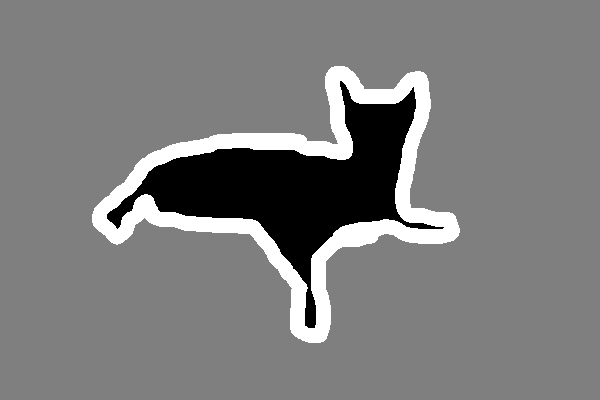

In [ ]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

# ImageOps.autocontrast() method maximizes (normalize) image contrast. 
# This function calculates a histogram of the input image, 
# removes cutoff percent of the lightest and darkest pixels from the histogram, 
# and remaps the image so that the darkest pixel becomes black (0), 
# and the lightest becomes white (255).

img = PIL.ImageOps.autocontrast(load_img(DATA_ROOT_DIR + 'annotations/trimaps/' + files[0] + '.png'))
display(img)

## Data Generator

In [ ]:
# reference: https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence
class OxfordPets(keras.utils.Sequence):
    def __init__(self, files):
        self.files = files
    def __len__(self):
        return math.ceil(len(self.files) / BATCH_SIZE)
    def __getitem__(self, index):
        x, y = [], []
        for i in range(index * BATCH_SIZE, min((index+1) * BATCH_SIZE, len(self.files))):
            # target size in load_img
            # (img_height, img_width)
            x.append(numpy.array(load_img(DATA_ROOT_DIR + 'images/' + self.files[i] + '.jpg', target_size = IMG_SIZE), dtype='float32'))
            y.append(numpy.array(load_img(DATA_ROOT_DIR + 'annotations/trimaps/' + self.files[i] + '.png', target_size = IMG_SIZE, color_mode="grayscale"), dtype='uint8'))

        return numpy.array(x), numpy.array(y)


## U-Net

In [ ]:
class ResBlock(keras.Model):
    def __init__(self, channels, strides=1):
        super().__init__()
        self.channels = channels
        self.conv1 = layers.Conv2D(channels, 3, strides=strides, padding='same')
        self.bn1 = layers.BatchNormalization()
        
        self.conv2 = layers.Conv2D(channels, 3, strides=1, padding='same')
        self.bn2 = layers.BatchNormalization()

        if strides != 1:
            self.residual = keras.Sequential()
            self.residual.add(layers.Conv2D(channels, 1, strides=strides, padding='same'))
        else:
            self.residual = lambda x: x
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        r = self.residual(inputs)
        outputs = layers.add([x,r])
        outputs = tf.nn.relu(outputs)
        return outputs

def buildBlock(channels, repeat, strides=1):
    resBlocks = keras.Sequential()
    
    resBlocks.add(ResBlock(channels, strides))

    for _ in range(1, repeat):
        resBlocks.add(ResBlock(channels, strides=1))
    
    return resBlocks

In [ ]:
class ChannelAttention(keras.Model):
    def __init__(self, inChannels, reduction):
        super().__init__()
        self.globalMaxPool = layers.GlobalMaxPooling2D(keepdims=True)
        self.globalAvgPool = layers.GlobalAveragePooling2D(keepdims=True)
        self.fc = keras.Sequential([
            layers.Conv2D(inChannels//reduction, 3, padding='same'),
            layers.ReLU(),
            layers.Conv2D(inChannels, 1, padding='valid')
        ])
    
    def call(self, inputs):
        x1 = self.globalMaxPool(inputs)
        x2 = self.globalAvgPool(inputs)
        x1 = self.fc(x1)
        x2 = self.fc(x2)
        x = tf.nn.sigmoid(layers.add([x1, x2]))
        return x

class SpatialAttention(keras.Model):
    def __init__(self):
        super().__init__()
        self.conv3x3 = layers.Conv2D(1, 3, padding='same')
    
    def call(self, inputs):
        # https://github.com/kobiso/CBAM-tensorflow/blob/master/attention_module.py#L95
        x1 = tf.math.reduce_max(inputs, axis=3, keepdims=True)
        x2 = tf.math.reduce_mean(inputs, axis=3, keepdims=True)
        x = tf.concat([x1, x2], 3)
        x = self.conv3x3(x)
        x = tf.nn.sigmoid(x)
        return x

class CBAM(keras.Model):
    def __init__(self, inChannels, reduction):
        super().__init__()
        self.channelAttention = ChannelAttention(inChannels, reduction)
        self.spaialAttention = SpatialAttention()
    
    def call(self, inputs):
        x = inputs * self.channelAttention(inputs)
        x = x * self.spaialAttention(x)
        return x

In [ ]:
class DecodeBlock(keras.Model):
    def __init__(self, inChannels, outChannels, upsample=True):
        super().__init__()
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.upsample = keras.Sequential()
        if upsample:
            self.upsample.add(layers.UpSampling2D(2, interpolation='nearest'))
        self.conv3x3_1 = layers.Conv2D(inChannels, 3, padding='same')
        self.conv3x3_2 = layers.Conv2D(outChannels, 3, padding='same')
        self.cbam = CBAM(outChannels, reduction=16)
        self.conv1x1 = layers.Conv2D(outChannels, 1, padding='valid')

    def call(self, inputs):
        x = tf.nn.relu(self.bn1(inputs))
        x = self.upsample(x)
        x = self.conv3x3_1(x)
        x = self.conv3x3_2(tf.nn.relu(self.bn2(x)))
        x = self.cbam(x)
        shortcut = self.conv1x1(self.upsample(inputs))
        x += shortcut
        return x


In [ ]:
def resnet34Unet(imgSize, outputSize):
    inputs = keras.Input(shape=imgSize+(3,))

    # Encode by ResNet34
    x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = tf.nn.relu(x)
    x0 = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
    # resnet34 is referenced by https://blog.csdn.net/Forrest97/article/details/106136435
    
    # resnet34 - layer1
    x1 = buildBlock(64, 3, strides=1)(x0)
    
    # resnet34 - layer2
    x2 = buildBlock(128, 4, strides=2)(x1)

    # resnet34 - layer3
    x3 = buildBlock(256, 6, strides=2)(x2)

    # resnet34 - layer4
    x4 = buildBlock(512, 3, strides=2)(x3)

    # centerblock
    y5 = layers.Conv2D(512, 3, padding='same')(x4)

    # Decode

    y4 = DecodeBlock(512+512, 64)(layers.Concatenate(axis=3)([x4, y5]))

    y3 = DecodeBlock(64+256, 64)(layers.Concatenate(axis=3)([x3, y4]))

    y2 = DecodeBlock(64+128, 64)(layers.Concatenate(axis=3)([x2, y3]))

    y1 = DecodeBlock(64+64, 64)(layers.Concatenate(axis=3)([x1, y2]))
    y0 = DecodeBlock(64, 64)(y1)

    # hypercolumn
    y4 = layers.UpSampling2D(16, interpolation='bilinear')(y4)
    y3 = layers.UpSampling2D(8, interpolation='bilinear')(y3)
    y2 = layers.UpSampling2D(4, interpolation='bilinear')(y2)
    y1 = layers.UpSampling2D(2, interpolation='bilinear')(y1)
    hypercolumn = layers.Concatenate(axis=3)([y0, y1, y2, y3, y4])

    # final conv
    outputs = keras.Sequential([
        layers.Conv2D(64, 3, padding='same'),
        layers.ELU(),
        # 這裡與原模型有差異，我們最後的特徵圖有4個channels
        layers.Conv2D(4, 1, padding='valid')
    ])(hypercolumn)

    outputs = tf.nn.softmax(outputs)

    return keras.Model(inputs, outputs)

keras.backend.clear_session()

## Start Training!

In [ ]:
m = resnet34Unet(IMG_SIZE, NUM_CLASSES)
m.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
tf.nn.relu (TFOpLambda)         (None, 80, 80, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
numpy.random.shuffle(files)
middle = math.ceil(len(files) * 0.8)
train = OxfordPets(files[:middle])
test = OxfordPets(files[middle:])

m.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
history = m.fit(train, validation_data=test, epochs=15)

Epoch 1/15
237/237 [==============================] - 202s 649ms/step - loss: 2.4395 - val_loss: 2.3987
Epoch 2/15
237/237 [==============================] - 150s 634ms/step - loss: 0.5949 - val_loss: 0.6891
Epoch 3/15
237/237 [==============================] - 150s 635ms/step - loss: 0.4587 - val_loss: 0.8186
Epoch 4/15
237/237 [==============================] - 150s 634ms/step - loss: 0.3988 - val_loss: 0.4630
Epoch 5/15
237/237 [==============================] - 150s 633ms/step - loss: 0.3596 - val_loss: 0.4362
Epoch 6/15
237/237 [==============================] - 150s 632ms/step - loss: 0.3340 - val_loss: 0.3567
Epoch 7/15
237/237 [==============================] - 150s 632ms/step - loss: 0.3097 - val_loss: 0.3767
Epoch 8/15
237/237 [==============================] - 150s 632ms/step - loss: 0.2882 - val_loss: 0.4110
Epoch 9/15
237/237 [==============================] - 150s 632ms/step - loss: 0.2689 - val_loss: 0.3719
Epoch 10/15
237/237 [==============================] - 150s 632m

# Evaluate

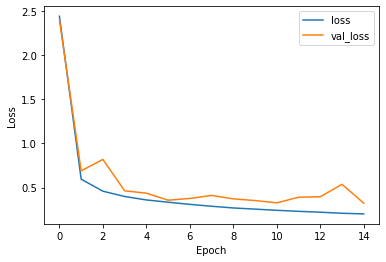

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

In [ ]:
def mask_to_img(predict):
    mask = numpy.argmax(predict, axis=-1)
    # numpy.expand_dims() expand the shape of an array.
    # Insert a new axis that will appear at the axis position in the expanded
    # array shape.
    mask = numpy.expand_dims(mask, axis = -1)
    return PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))

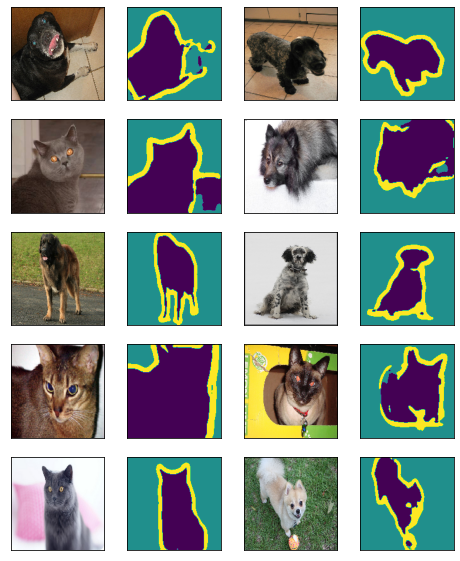

In [ ]:
demo_data = OxfordPets(files[:10])
demo_res = m.predict(demo_data)

plt.figure(figsize=(8, 10))
for i in range(10):
    plt.subplot(5, 4, i*2+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(keras.preprocessing.image.array_to_img(demo_data.__getitem__(0)[0][i]))
    plt.subplot(5, 4, i*2+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(mask_to_img(demo_res[i]))

plt.show()
plt.close()